In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,network_ffrec,connectivity,inputs,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-09-15 15:37:25.222743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Build Connectivity Matrices

In [3]:
Version = -1
config_name = 'ffrec_stevens'

In [4]:
config_dict,N4pop,NTpop,NR,NT,N4,rA = uf.get_network_size(config_name)
confRtoT_dict = config_dict['Wret_to_lgn_params']
confTto4_dict = config_dict['Wlgn_to4_params']
conf4to4_dict = config_dict['W4to4_params']
N = N4

MISC params_dict params_ffrec_stevens {'Nret': 96, 'Nlgn': 96, 'N4': 96, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 1.5, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'q_dict': True, 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_rect', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.037, 'sigma2': 0.15, 'ampl1': 1.0, 'ampl2': 1.0, 'gamma_ret': 1, 'noise': 0.0, 'stevensetal': True, 'profile': 'Mexican-hat'}, 'Wlgn_to4_params': {'sigma

In [5]:
xs,ys = np.meshgrid(np.arange(N)/N,np.arange(N)/N)
dxs = np.abs(xs.flatten()[:,None] - xs.flatten()[None,:])
dxs[dxs > 0.5] = 1 - dxs[dxs > 0.5]
dys = np.abs(ys.flatten()[:,None] - ys.flatten()[None,:])
dys[dys > 0.5] = 1 - dys[dys > 0.5]
ds = np.sqrt(dxs**2 + dys**2)

dists = np.linspace(0,0.71,72)

def get_dist_shape(A):
    bin_idxs = np.digitize(ds,np.linspace(0,0.7,71)+0.005)

    A_d = np.zeros(72)

    for idx in range(72):
        A_d[idx] = np.mean(A[bin_idxs == idx])
        
    return A_d

In [6]:
def gauss2d_shape(x,m,v):
    return np.exp(-0.5*(x-m)**2/v)/(2*np.pi*v)

In [7]:
start = time.process_time()

WRtoT,WTto4,AN,AF,AT,W0Tto4,W4to4,A4to4,W04to4=uf.get_network_system_ffrec(Version,config_name)

print('Building connectivity matrices took',time.process_time() - start,'s')

Building connectivity matrices took 346.660441 s


## Build Retino-Thalamic Connectivity Matrix

In [8]:
# reload(connectivity)

# conn = connectivity.Connectivity((N,N),(N,N),0)
# WRtoT,_ = conn.create_matrix(confRtoT_dict,confRtoT_dict['profile'])
WRtoT_d = get_dist_shape(WRtoT)

Text(0.5, 1.0, 'Retino-Thalamic Weight Kernel')

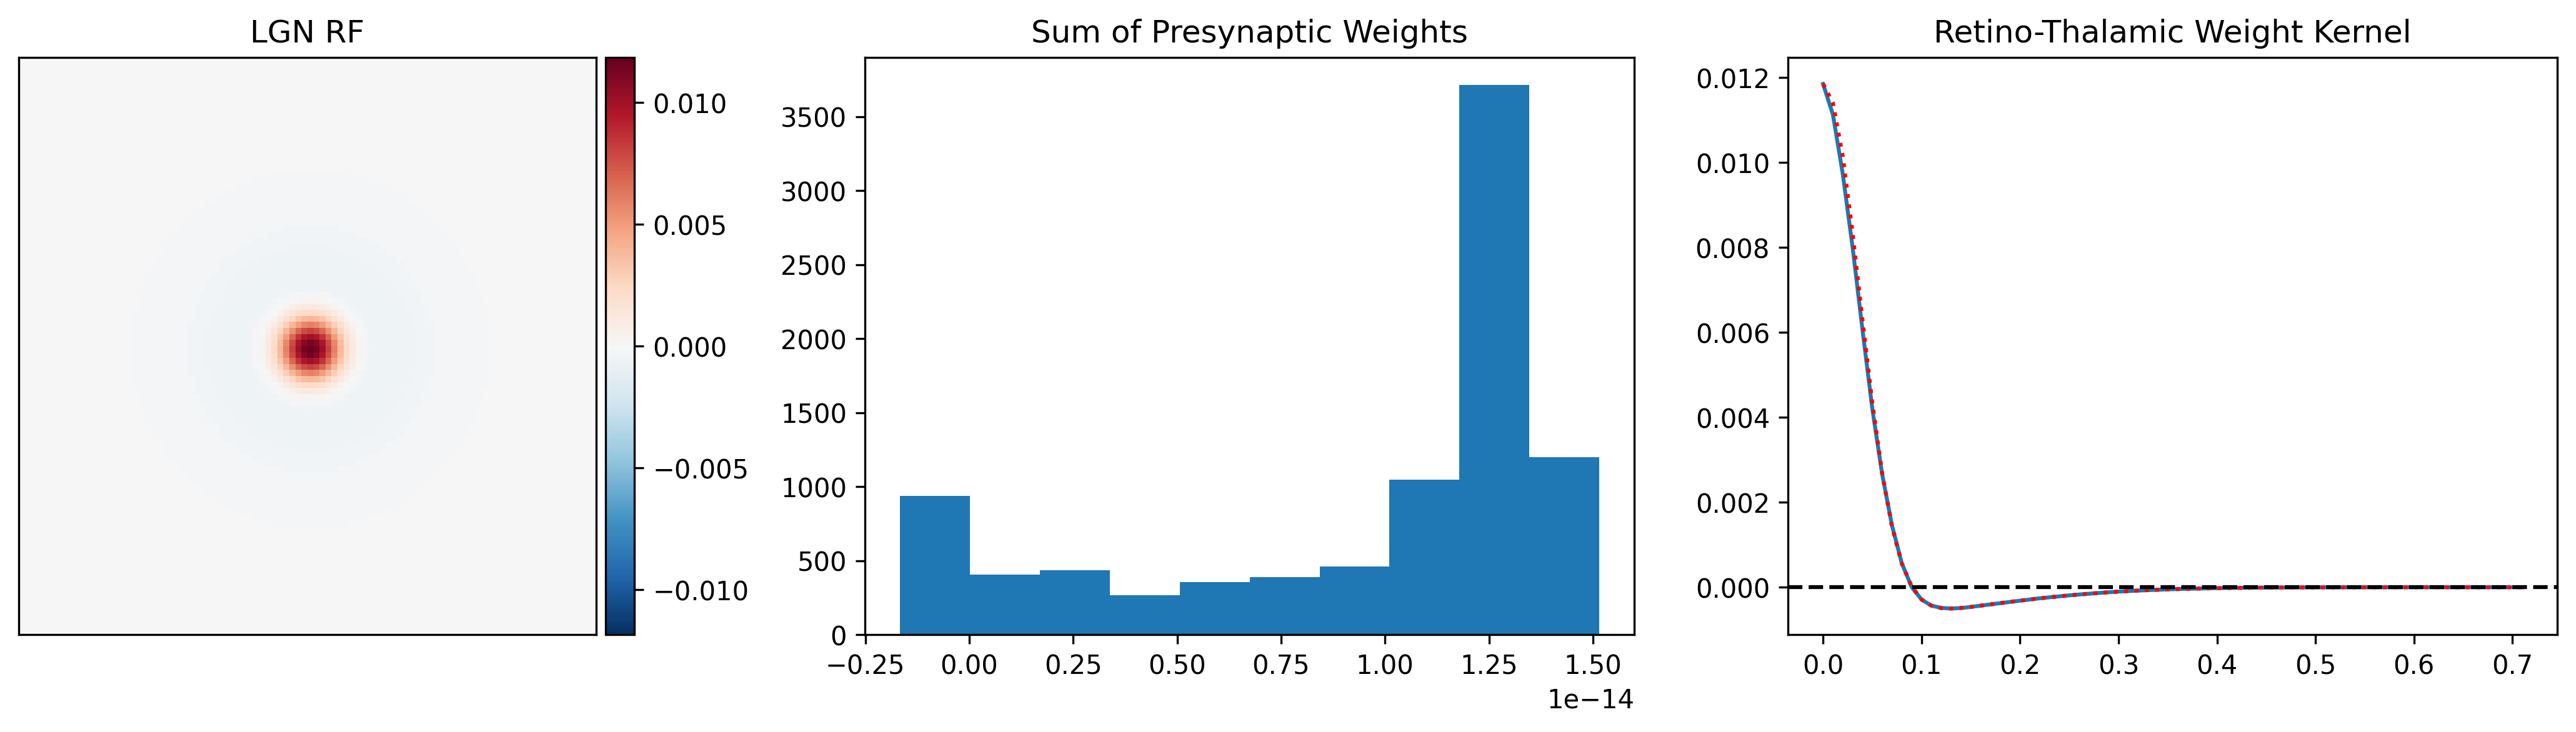

In [9]:
fig,axs = plt.subplots(1,3,figsize=(18,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WRtoT.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WRtoT)),vmax=np.max(np.abs(WRtoT)))

axs[1].hist(np.sum(WRtoT,1),10)

axs[2].plot(dists,WRtoT_d)
axs[2].plot(dists,(gauss2d_shape(dists,0,confRtoT_dict['sigma1']**2)-\
                   gauss2d_shape(dists,0,confRtoT_dict['sigma2']**2))/N**2,'r:')
axs[2].axhline(0,c='k',ls='--')

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')
axs[2].set_title('Retino-Thalamic Weight Kernel')

## Build Thalamo-Cortical Connectivity Matrix

In [10]:
WNtoE = WTto4[0]
WFtoE = WTto4[1]
WNtoI = WTto4[2]
WFtoI = WTto4[3]

WNtoE_d = get_dist_shape(WNtoE)

Text(0.5, 1.0, 'Retino-Thalamic Weight Kernel')

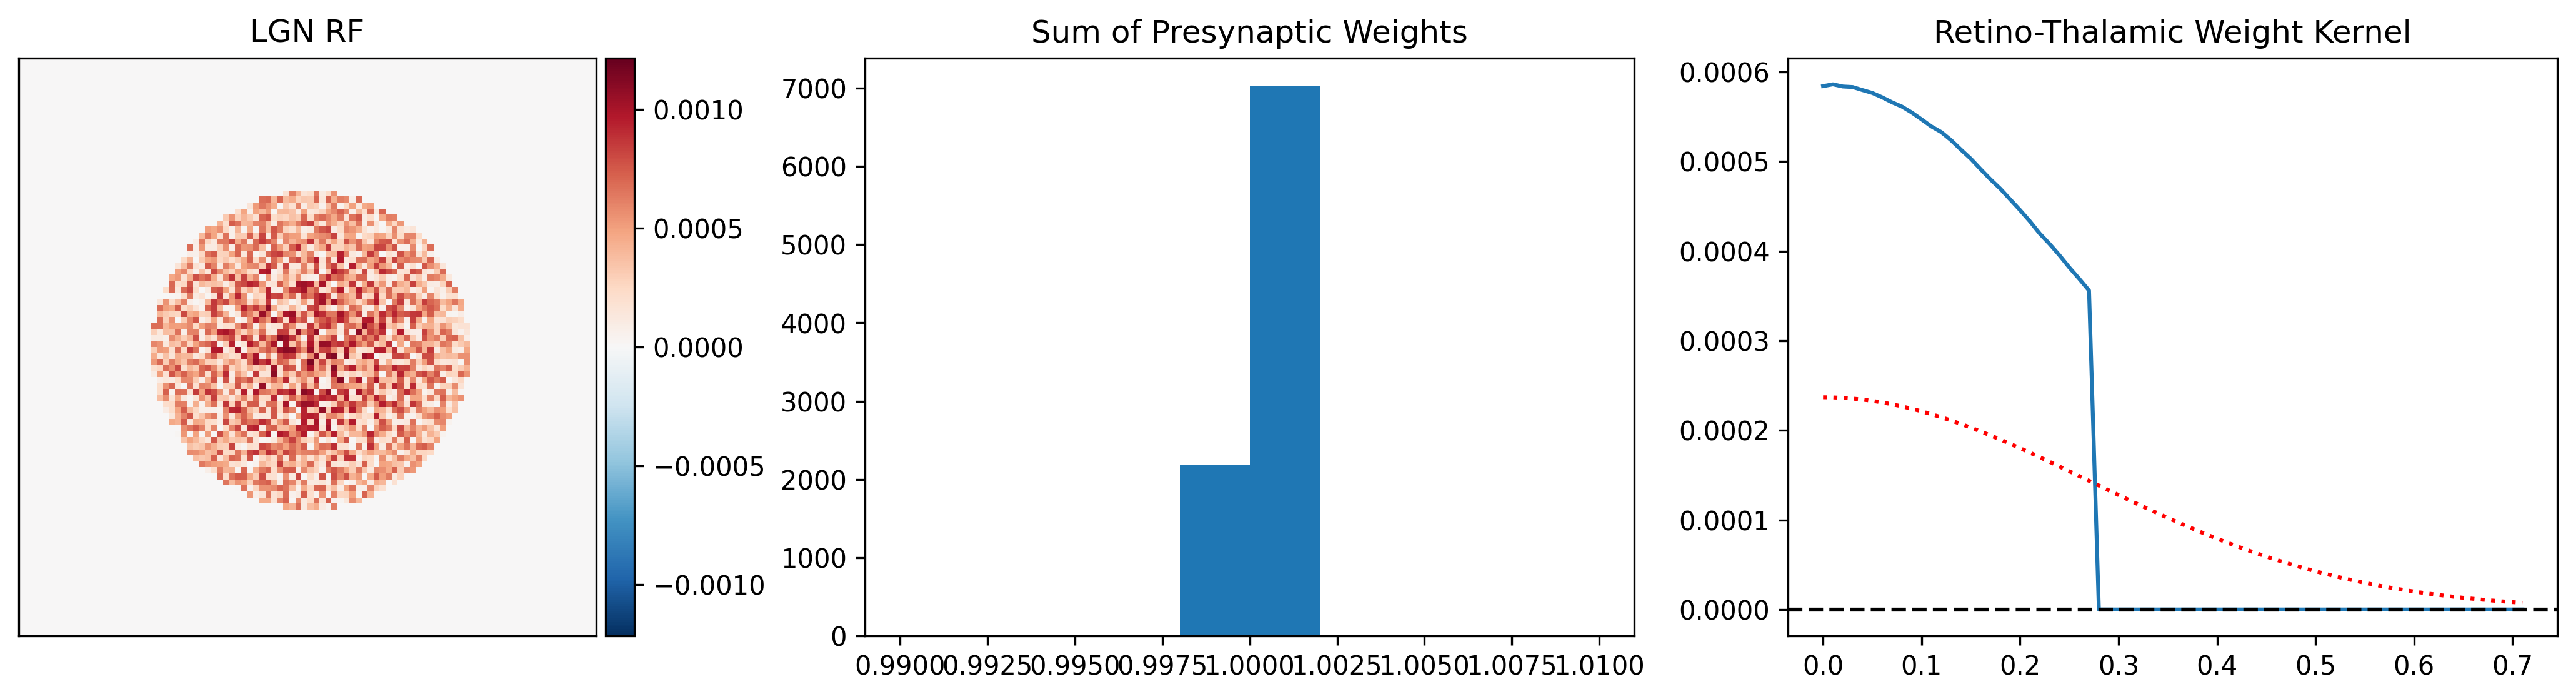

In [11]:
fig,axs = plt.subplots(1,3,figsize=(18,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WNtoE.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WNtoE)),vmax=np.max(np.abs(WNtoE)))

Wpresum = np.sum(WNtoE,1)
axs[1].hist(Wpresum,np.linspace(np.min(Wpresum)*0.99,np.max(Wpresum)*1.01,11))

axs[2].plot(dists,WNtoE_d)
axs[2].plot(dists,gauss2d_shape(dists,0,confTto4_dict['sigma']**2)/N**2,'r:')
axs[2].axhline(0,c='k',ls='--')

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')
axs[2].set_title('Retino-Thalamic Weight Kernel')

## Build Excitatory Cortico-Cortical Connectivity Matrix

In [12]:
WEtoE = W4to4[:N4**2,:N4**2]
WEtoI = W4to4[N4**2:,:N4**2]

WEtoE_d = get_dist_shape(WEtoE)
WEtoI_d = get_dist_shape(WEtoI)

Text(0.5, 1.0, 'Retino-Thalamic Weight Kernel')

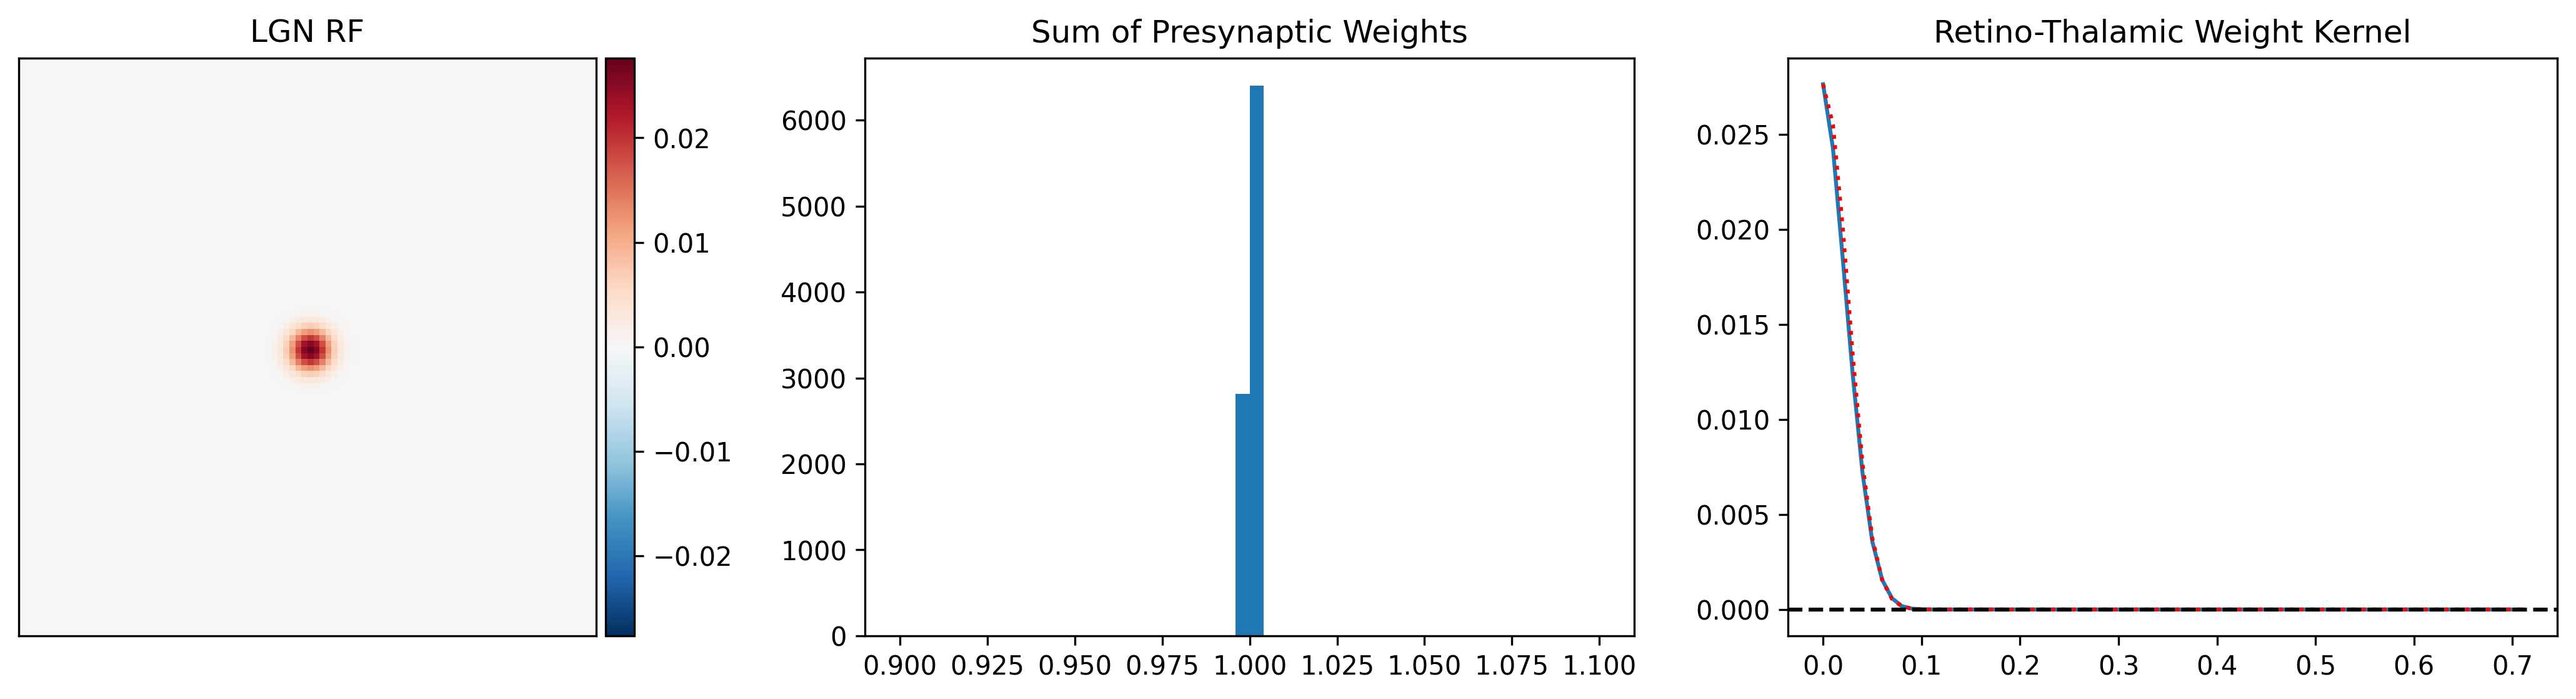

In [13]:
fig,axs = plt.subplots(1,3,figsize=(18,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WEtoE.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WEtoE)),vmax=np.max(np.abs(WEtoE)))

Wpresum = np.sum(WEtoE,1)
axs[1].hist(Wpresum,np.linspace(np.min(Wpresum)*0.9,np.max(Wpresum)*1.1,51))

axs[2].plot(dists,WEtoE_d)
axs[2].plot(dists,gauss2d_shape(dists,0,conf4to4_dict['sigma_EE']**2)/N**2,'r:')
axs[2].axhline(0,c='k',ls='--')

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')
axs[2].set_title('Retino-Thalamic Weight Kernel')

## Build Inhibitory Cortico-Cortical Connectivity Matrix

In [14]:
WItoE = W4to4[:N4**2,N4**2:]
WItoI = W4to4[N4**2:,N4**2:]

WItoE_d = get_dist_shape(WItoE)
WItoI_d = get_dist_shape(WItoI)

Text(0.5, 1.0, 'Retino-Thalamic Weight Kernel')

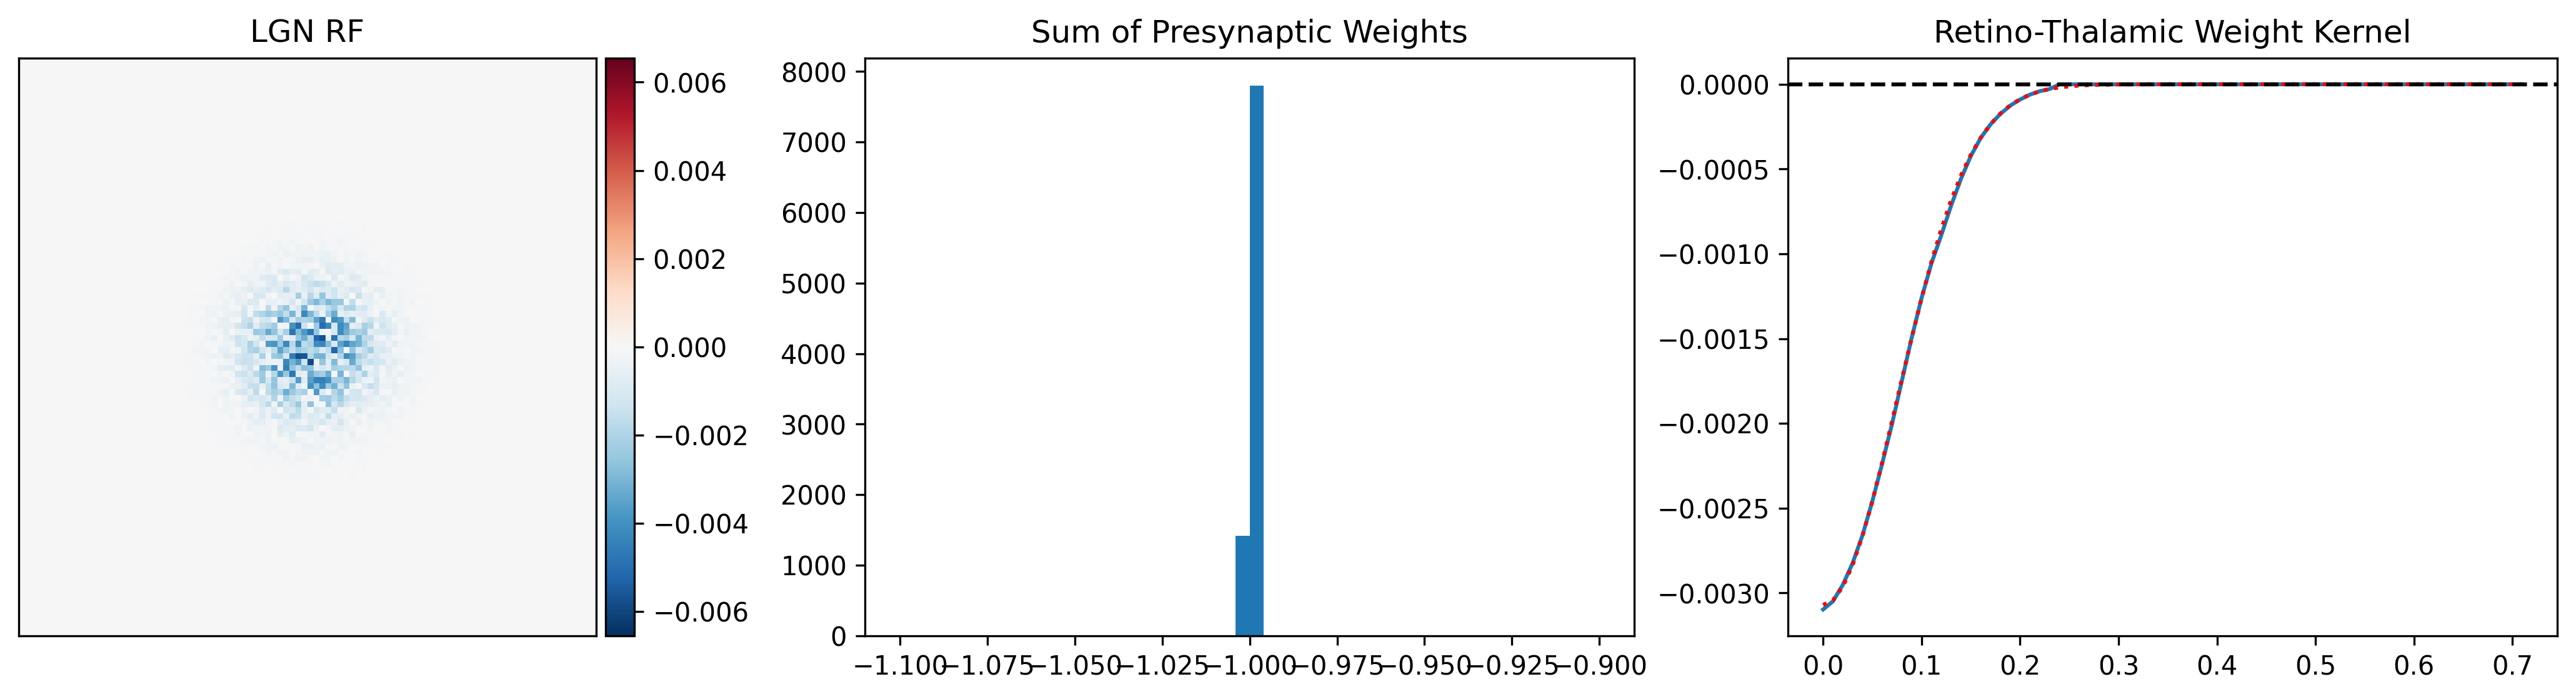

In [15]:
fig,axs = plt.subplots(1,3,figsize=(18,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

pf.imshowbar(fig,axs[0],WItoE.reshape(N,N,N,N)[N//2,N//2,:,:],
          vmin=-np.max(np.abs(WItoE)),vmax=np.max(np.abs(WItoE)))

Wpresum = np.sum(WItoE,1)
axs[1].hist(Wpresum,np.linspace(np.min(Wpresum)*1.1,np.max(Wpresum)*0.9,51))

axs[2].plot(dists,WItoE_d)
axs[2].plot(dists,-gauss2d_shape(dists,0,conf4to4_dict['sigma_EI']**2)/N**2,'r:')
axs[2].axhline(0,c='k',ls='--')

axs[0].set_title('LGN RF')
axs[1].set_title('Sum of Presynaptic Weights')
axs[2].set_title('Retino-Thalamic Weight Kernel')